<a href="https://colab.research.google.com/github/NREL/BEEAM/blob/develop/FMU/flexlab_demo/5_notebooks/calibration_NMBE_CVRMSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# connect to goolgle drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Purpose
Reads the CSV file from the OpenStudio [Timeseries Objective Function Reporting Measure](https://github.com/NREL/openstudio-calibration-gem/tree/develop/lib/measures/TimeseriesObjectiveFunction) and plots results.

In [ ]:
# import libraries
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

# 1 Setup

In [ ]:
# dir
csv_dir = '/content/drive/Shared drives/NREL DC Design Tool/Tasks/7 Validation/7.2 Whole Tool Validation/FLEXLAB/NREL OpenStudio Model/3 Calibration'

# names
# csv_name = 'timeseriesCalibration Arch Plnm.csv'
csv_name = 'timeseriesCalibration Arch Zone.csv'
# csv_name = 'timeseriesCalibration Mech Clg.csv'
# csv_name = 'timeseriesCalibration Mech Fan.csv'

# csv_name = 'timeseriesUncalibrated Arch Plnm.csv'
# csv_name = 'timeseriesUncalibrated Arch Zone.csv'
# csv_name = 'timeseriesUncalibrated Mech Clg.csv'
# csv_name = 'timeseriesUncalibrated Mech Fan.csv'

# path
csv_path = os.path.join(csv_dir, csv_name)

# array of columns to remove (set to False if NA)
cols_to_drop = ['Metered time'] #False

# column names for calculations (must match renamed columns if applicable)
observed_column_name = 'Measured'
predicted_column_name = 'Modeled'

# array of desired column names, in order, after dropping, if applicable (set to False if NA)
col_name_dict = {'Simulation Time':'datetime',
                 'Simulated Value':predicted_column_name,
                 'Metered Value':observed_column_name}

# column index (after dropping or renaming columns)
col_index = 'datetime'

# beginning and end timestamps to slice dataset (if desired)
# in 'YYYY-MM-DD HH:MM:SS' format (set to False if NA)
beg = False
end = False

# plot title
title = csv_name.strip('timeseries').strip('.csv') #.strip('.').strip('_initial') #.strip('_') #'Architectural Test Plenum Temperature Calibration'
print(title)

# plot axis labels
xlabel = 'Date'
ylabel = 'Temperature (C)'
# ylabel = 'Cooling Load (W)'
# ylabel = 'Fan Power (W)'

# plot file name
png_name = title.replace(' ', '_').lower() + '.png'
print(png_name)
dpi = 300

# size
# aspect = 2

# plot observed and predicted colors
obs_clr = 'orange'
pre_clr = 'purple'

# yaxis min, max, and multiple for rounding
# if none, min and max will be rounded based on data and multiple

ymin = 18
ymax = 38
ymult = 1

# ymin = 0
# ymax = 2200 
# ymult = 1000 

# legend location
legend_location = 'upper left'
# legend_location = 'upper right'

Calibration Arch Zone
calibration_arch_zone.png


# 2 Extract

In [ ]:
# read csv
df = pd.read_csv(csv_path)

# show
df

,Simulation Time,Simulated Value,Metered time,Metered Value
0,2020/10/30 00:00:00,25.477778,2020/10/30 00:00:00,25.642054
1,2020/10/30 00:15:00,25.796529,2020/10/30 00:15:00,25.685371
2,2020/10/30 00:30:00,25.928234,2020/10/30 00:30:00,25.733244
3,2020/10/30 00:45:00,26.057832,2020/10/30 00:45:00,25.775576
4,2020/10/30 01:00:00,26.161660,2020/10/30 01:00:00,25.817978
...,...,...,...,...
542,2020/11/04 15:30:00,36.925318,2020/11/04 15:30:00,37.302730
543,2020/11/04 15:45:00,36.953757,2020/11/04 15:45:00,37.357245
544,2020/11/04 16:00:00,36.982672,2020/11/04 16:00:00,37.402714
545,2020/11/04 16:15:00,37.007788,2020/11/04 16:15:00,37.447809


# 3 Transform

## 3.1 Dataframe to Plot

In [ ]:
# drop columns
if len(cols_to_drop) > 0:
    df.drop(labels=cols_to_drop, axis=1, inplace=True)

# change column names
if len(col_name_dict) > 0:
    df.rename(columns=col_name_dict, inplace=True)

# convert column index to datetime format
df[col_index] = pd.to_datetime(df[col_index])

# set index
df.set_index(col_index, inplace=True)

# slice dataframe
if beg and not end:
    df = df[beg:df.index[-1]]
elif end and not beg:
    df = df[df.index[0]:end]
elif beg and end:
    df = df[beg:end]

# show dataframe
df

,Modeled,Measured
datetime,,
2020-10-30 00:00:00,25.477778,25.642054
2020-10-30 00:15:00,25.796529,25.685371
2020-10-30 00:30:00,25.928234,25.733244
2020-10-30 00:45:00,26.057832,25.775576
2020-10-30 01:00:00,26.161660,25.817978
...,...,...
2020-11-04 15:30:00,36.925318,37.302730
2020-11-04 15:45:00,36.953757,37.357245
2020-11-04 16:00:00,36.982672,37.402714


## 3.2 Dataframe for Calculations

In [ ]:
# new dataframe for calculations
df_calcs = df.copy()

# calculate difference of predicted and observed for NMBE
df_calcs['(obs - pre)'] = df_calcs[observed_column_name] - df_calcs[predicted_column_name]
df_calcs

# calculate the square of the difference for CV(RMSE)
df_calcs['(obs - pre)^2'] = df_calcs['(obs - pre)']**2
df_calcs

,Modeled,Measured,(obs - pre),(obs - pre)^2
datetime,,,,
2020-10-30 00:00:00,25.477778,25.642054,0.164276,0.026987
2020-10-30 00:15:00,25.796529,25.685371,-0.111158,0.012356
2020-10-30 00:30:00,25.928234,25.733244,-0.194990,0.038021
2020-10-30 00:45:00,26.057832,25.775576,-0.282256,0.079668
2020-10-30 01:00:00,26.161660,25.817978,-0.343682,0.118117
...,...,...,...,...
2020-11-04 15:30:00,36.925318,37.302730,0.377412,0.142440
2020-11-04 15:45:00,36.953757,37.357245,0.403488,0.162803
2020-11-04 16:00:00,36.982672,37.402714,0.420042,0.176435


# 4 Load

## 4.1 Calculate NMBE and CV(RMSE)

$ NMBE = \sum_{i=1}^n (y_i - \hat{y_i} ) / (n - p) * \bar{y} $

$ CV(RMSE) = \sqrt{ \sum{ (y_i - \hat{y_i})^2 } / (n - p) } / \bar{y} $

where

> $ y_i = $ single observed (measured) value
>
> $ \hat{y_i} = $ single predicted (modeled) value
>
> $ n = $ number of data points or periods
>
> $ p = $ number of parameters or terms in the
baseline model
>
> $ \bar{y} = $ arithmetic mean of the sample of n
observations


In [ ]:
# NMBE sum
nmbe_sum = df_calcs['(obs - pre)'].sum()
print(f'NMBE sum = {nmbe_sum}')

# sum of sqaures for CV(RMSE)
cvrmse_sum = df_calcs['(obs - pre)^2'].sum()
print(f'CV(RMSE) sum = {cvrmse_sum}')

# number of data points
n = len(df_calcs.index)
print(f'n = {n}')

# number of parameters
p = 1

# mean of samples
y_bar = df_calcs[observed_column_name].mean()
print(f'y_bar = {y_bar}')

print('')

# calculate NMBE
nmbe = nmbe_sum / ((n - p) * y_bar)
nmbe_pct = nmbe * 100
print(f'NMBE = {nmbe}')

# calculate CV(RMSE)
cvrmse = (cvrmse_sum / (n - p))**0.5 / y_bar
cvrmse_pct = cvrmse * 100
print(f'CV(RMSE) = {cvrmse}')

NMBE sum = 2.126390999999959
CV(RMSE) sum = 104.27827792675691
n = 547
y_bar = 34.46280695978064

NMBE = 0.00011300556613203176
CV(RMSE) = 0.012680896459761235


## 4.2 Plot

In [ ]:
df.describe()

,Modeled,Measured
count,547.000000,547.000000
mean,34.458920,34.462807
std,2.851508,2.911484
min,25.477778,25.642054
25%,32.978199,32.763966
50%,35.914022,35.586082
75%,36.356211,36.315715
max,37.172744,37.488719


In [ ]:
# get min and max for axis scale
pre_min = df[predicted_column_name].min()
pre_max = df[predicted_column_name].max()

obs_min = df[observed_column_name].min()
obs_max = df[observed_column_name].max()

abs_min = min(pre_min, obs_min)
abs_max = max(pre_max, obs_max)
print(abs_min, abs_max)

# yaxis minimum value
if ymin == None:
    rnd_min = abs_min - abs_min % ymult # math.floor(abs_min)
else:
    rnd_min = ymin

# yaxis maximum value
if ymax == None:
    rnd_max = math.ceil(abs_max / ymult) * ymult #round(abs_max, -1)
else:
    rnd_max = ymax

print(rnd_min, rnd_max)

# get max time for annotation location
# time_max = df.index[-1]
# time_max

25.477778 37.488719
18 38


(18.0, 38.0)

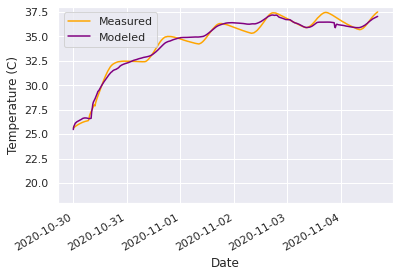

In [ ]:
# use Seaborn's default theme
sns.set_theme()

# create figure and axis
fig, ax = plt.subplots()

# set title and axis labels
# ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# add data
ax.plot(df.index, df[observed_column_name], label=observed_column_name, color=obs_clr)
ax.plot(df.index, df[predicted_column_name], label=predicted_column_name, color=pre_clr)

# add legend
ax.legend(loc=legend_location) #bbox_to_anchor=(1, 1), loc='center right') #loc='best')

# format x-axis
ax.figure.autofmt_xdate()

# format y-axis
ax.set_ylim(ymin=rnd_min, ymax=rnd_max)

0.0% NMBE
1.3% CV(RMSE)


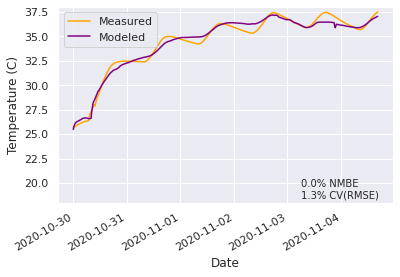

In [ ]:
# annotation text, note s is a deprecated synonym for text
text = f'{nmbe_pct:.1f}% NMBE\n{cvrmse_pct:.1f}% CV(RMSE)'
print(text)

# add (or remove) annotation
annotation = ax.annotate(s=text, xy=(0.725, 0.025), xycoords='axes fraction', fontsize=10)
# annotation.remove()

fig

In [ ]:
# save
fig.savefig(os.path.join(csv_dir, png_name), bbox_inches='tight', dpi=dpi)

In [ ]:
# add annotation
# bbox_dict = )
# ax.text(time_max, rnd_min, f'NMBE = {nmbe_pct:.1f} ', bbox=bbox_dict)

# set seaborn theme
sns.set_theme()

#
plot = sns.relplot(data=df, kind='line', aspect=2)
plot.fig.autofmt_xdate()
plot.set(title=title, xlabel=xlabel, ylabel=ylabel, ylim=(rnd_min, rnd_max))